# Lab Three: Clustering, Association Rules, Recommenders
### Laura Ahumada, Kevin Boyd, Shikha Pandey, Duy Nguyen
##### Southern Methodist University
##### Fall, 2022

# Business Understanding
* Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

#####

# Data Understanding Part 1
* Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

This dataset (ml-25m) describes 5-star rating activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 25,000,095 ratings across 62,423 movies; 59,047 of which are actually rated. These data were created by 162,541 users between January 09, 1995 and November 21, 2019. This dataset was generated on November 21, 2019.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

#####

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [16]:
#Reading the files
df_movies = pd.read_csv('movies.csv')
df_ratings = pd.read_csv('ratings.csv')

#Merging the Dataset
df_merge1=df_movies.merge(df_ratings,on="movieId")
df_merge1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000095 entries, 0 to 25000094
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   title      object 
 2   genres     object 
 3   userId     int64  
 4   rating     float64
 5   timestamp  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.3+ GB


In [30]:
print("Total number of ratings: ", df_merge1.shape[0])
print("Total number of unique users =", len(df_ratings.userId.unique()))
print("")
print("Total number of unique movies: ", len(df_movies.movieId.unique()))
print("Total number of unique rated movies =", len(df_ratings.movieId.unique()))

Total number of ratings:  25000095
Total number of unique users = 162541

Total number of unique movies:  62423
Total number of unique rated movies = 59047


### Missing Values
No missing value are found.

In [34]:
df_merge1.isnull().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

### Duplicated Values
No duplicated values are found.

In [36]:
df_merge1[df_merge1.duplicated(keep='first')].sum()

movieId      0.0
title        0.0
genres       0.0
userId       0.0
rating       0.0
timestamp    0.0
dtype: float64

### Outliers
Surprisingly there are only 2 outliers, one rating recorded as 1 and one rating as 0.5, out of the 2.5M ratings. These two shouldn't be counted as mistakes...?

{'whiskers': [<matplotlib.lines.Line2D at 0x2673a72cbe0>,
 'caps': [<matplotlib.lines.Line2D at 0x2673a72d120>,
 'boxes': [<matplotlib.lines.Line2D at 0x2673a72ca60>],
 'medians': [<matplotlib.lines.Line2D at 0x2673a72d660>],
 'fliers': [<matplotlib.lines.Line2D at 0x2673a72d900>],
 'means': []}

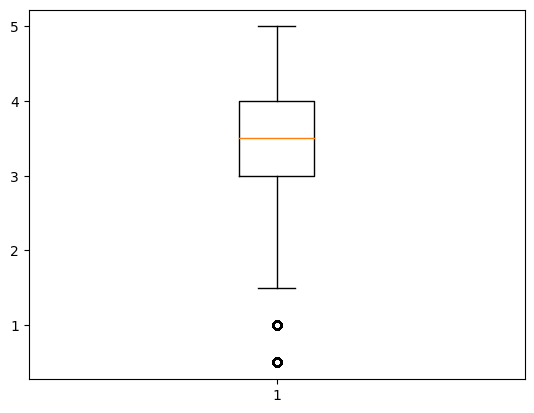

In [38]:
plt.boxplot(df_merge1['rating'])

### Descriptive Statistics for each Movie

In [31]:
#Modify df to our getting info on rating saving it on its own column
updated=df_merge1.groupby("movieId").agg({"rating":("count",np.mean, np.median, np.std), "title":['first'],"genres":['first']})
updated=updated.reset_index()
#Fix columns names
updated.columns=["MovieId","TotalRatings","RatingMean","RatingMedian","RatingStd","Title","Genres"]

In [32]:
#View of the grouped list
updated

,MovieId,TotalRatings,RatingMean,RatingMedian,RatingStd,Title,Genres
0,1,57309,3.893708,4.0,0.921552,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,24228,3.251527,3.0,0.959851,Jumanji (1995),Adventure|Children|Fantasy
2,3,11804,3.142028,3.0,1.008443,Grumpier Old Men (1995),Comedy|Romance
3,4,2523,2.853547,3.0,1.108531,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,11714,3.058434,3.0,0.996611,Father of the Bride Part II (1995),Comedy
...,...,...,...,...,...,...,...
59042,209157,1,1.500000,1.5,NaN,We (2018),Drama
59043,209159,1,3.000000,3.0,NaN,Window of the Soul (2001),Documentary
59044,209163,1,4.500000,4.5,NaN,Bad Poems (2018),Comedy|Drama
59045,209169,1,3.000000,3.0,NaN,A Girl Thing (2001),(no genres listed)


### What shall we do with these movies? We have enough data, I think we should remove

In [349]:
#323 movies don't have year
#(set(updated[updated["Year"].apply(lambda x: len(str(x)) < 4)]["Title"]))

In [360]:
#Removing Year from the title and creating a year column
import re
updated['Year']=updated['Title'].str.findall(r'([-+]?\d*\.\d+|\d+)').str[-1]
updated['Title']=updated["Title"].replace('[0-9,()]+','',regex=True)

In [358]:
#There are numerous movies that have the same title and year
updated[updated["Title"]=="Emma (1996)"]

,MovieId,TotalRatings,RatingMean,RatingMedian,RatingStd,Title,Genres,Year
650,838,30,3.916667,4.0,0.881646,Emma (1996),Comedy|Drama|Romance,1996
5601,26958,1,3.500000,3.5,NaN,Emma (1996),Romance,1996


In [361]:
#We have genres of each movie as a list let make it into its own column
updated.head()

,MovieId,TotalRatings,RatingMean,RatingMedian,RatingStd,Title,Genres,Year
0,1,215,3.920930,4.0,0.834859,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,110,3.431818,3.5,0.881713,Jumanji,Adventure|Children|Fantasy,1995
2,3,52,3.259615,3.0,1.054823,Grumpier Old Men,Comedy|Romance,1995
3,4,7,2.357143,3.0,0.852168,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,49,3.071429,3.0,0.907148,Father of the Bride Part II,Comedy,1995


In [362]:
# Now let's update Genres by setting a column for each and removing the current Genres column

#all genres
genres_list=set([x  for y in updated['Genres'] for x in y.split("|")])

#Create Column for each of the Genres
for i in genres_list:
    updated[i]=["Yes" if i in x.split("|") else "No" for x in updated["Genres"]]
    
#droping Genres column
updated=updated.drop("Genres",axis=1)


In [363]:
# Data set with all values which we are interested in
updated.head()

,MovieId,TotalRatings,RatingMean,RatingMedian,RatingStd,Title,Year,Comedy,War,Animation,...,Drama,Adventure,IMAX,Children,Crime,Documentary,Fantasy,Musical,Horror,Western
0,1,215,3.920930,4.0,0.834859,Toy Story,1995,Yes,No,Yes,...,No,Yes,No,Yes,No,No,Yes,No,No,No
1,2,110,3.431818,3.5,0.881713,Jumanji,1995,No,No,No,...,No,Yes,No,Yes,No,No,Yes,No,No,No
2,3,52,3.259615,3.0,1.054823,Grumpier Old Men,1995,Yes,No,No,...,No,No,No,No,No,No,No,No,No,No
3,4,7,2.357143,3.0,0.852168,Waiting to Exhale,1995,Yes,No,No,...,Yes,No,No,No,No,No,No,No,No,No
4,5,49,3.071429,3.0,0.907148,Father of the Bride Part II,1995,Yes,No,No,...,No,No,No,No,No,No,No,No,No,No


In [370]:
updated["Year"].unique()

array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '2005', '2006', '1902', '5', '1903', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '1908', nan, '2'], dtype=object)

In [385]:
#updated[updated["Year"].apply(lambda x: len(str(x))<4]
updated[updated["Year"].apply(lambda x: len(str(x)) < 4)]

,MovieId,TotalRatings,RatingMean,RatingMedian,RatingStd,Title,Year,Comedy,War,Animation,...,Drama,Adventure,IMAX,Children,Crime,Documentary,Fantasy,Musical,Horror,Western
6059,40697,2,2.25,2.25,2.474874,Babylon,5,No,No,No,...,No,No,No,No,No,No,No,No,No,No
9031,140956,4,3.50,3.25,0.707107,Ready Player One,NaN,No,No,No,...,No,No,No,No,No,No,No,No,No,No
9091,143410,1,2.00,2.00,NaN,Hyena Road,NaN,No,No,No,...,No,No,No,No,No,No,No,No,No,No
9138,147250,1,5.00,5.00,NaN,The Adventures of Sherlock Holmes and Doctor W...,NaN,No,No,No,...,No,No,No,No,No,No,No,No,No,No
9179,149334,1,3.00,3.00,NaN,Nocturnal Animals,NaN,No,No,No,...,Yes,No,No,No,No,No,No,No,No,No
9259,156605,1,4.50,4.50,NaN,Paterson,NaN,No,No,No,...,No,No,No,No,No,No,No,No,No,No
9367,162414,1,5.00,5.00,NaN,Moonlight,NaN,No,No,No,...,Yes,No,No,No,No,No,No,No,No,No
9448,167570,1,4.00,4.00,NaN,The OA,NaN,No,No,No,...,No,No,No,No,No,No,No,No,No,No
9514,171495,2,4.50,4.50,0.707107,Cosmos,NaN,No,No,No,...,No,No,No,No,No,No,No,No,No,No
9515,171631,1,1.00,1.00,NaN,Maria Bamford: Old Baby,NaN,No,No,No,...,No,No,No,No,No,No,No,No,No,No


In [364]:
#Let's update the columns"no Genres listed" to Unkown
updated.rename(columns={"(no genres listed)":"Unknown"}, inplace=True)
#droping MoviesID as that is not useful for our model nor EDA
ModelData=updated.drop("MovieId",axis=1)

In [235]:
ModelData.columns

Index(['TotalRatings', 'RatingMean', 'RatingMedian', 'RatingStd', 'Title',
       'Year', 'Comedy', 'War', 'Animation', 'Film-Noir', 'Action', 'Romance',
       'Thriller', 'Unknown', 'Sci-Fi', 'Mystery', 'Drama', 'Adventure',
       'IMAX', 'Children', 'Crime', 'Documentary', 'Fantasy', 'Musical',
       'Horror', 'Western'],
      dtype='object')

+ The Mean and Median ratings are pretty close showing that there could be very few outliers
+ We can see that there was movies with no ratings

In [91]:
ModelData.describe()

,MovieId,TotalRatings,RatingMean,RatingMedian,RatingStd
count,58098.000000,58098.000000,53889.000000,53889.000000,43734.000000
mean,111919.516197,477.700506,3.068593,3.121050,0.943670
std,59862.660956,2829.603251,0.736242,0.792195,0.398084
min,1.000000,0.000000,0.500000,0.500000,0.000000
25%,72437.750000,2.000000,2.687500,2.750000,0.748013
50%,126549.000000,5.000000,3.156250,3.000000,0.959007
75%,161449.500000,39.000000,3.500000,3.500000,1.129443
max,193886.000000,97999.000000,5.000000,5.000000,3.181981


# !!! There are 18 entries movies without ratings we may need to drop these entries therefore we will remove it

In [369]:
ModelData[ModelData["TotalRatings"]==0]["Title"]

816                          Innocents The 
2211                               Niagara 
2499                       For All Mankind 
2587    Color of Paradise The Rang-e khoda 
3118               I Know Where I'm Going! 
4037                            Chosen The 
4506     Road Home The Wo de fu qin mu qin 
4598                               Scrooge 
4704                                 Proof 
5020                     Parallax View The 
5293                     This Gun for Hire 
5421                  Roaring Twenties The 
5452                  Mutiny on the Bounty 
5749           In the Realms of the Unreal 
5824                     Twentieth Century 
5837                       Call Northside  
5957                  Browning Version The 
7565                           Chalet Girl 
Name: Title, dtype: object

In [92]:
updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MovieId       58098 non-null  int64  
 1   TotalRatings  58098 non-null  int64  
 2   RatingMean    53889 non-null  float64
 3   RatingMedian  53889 non-null  float64
 4   RatingStd     43734 non-null  float64
 5   Title         58098 non-null  object 
 6   Year          57776 non-null  object 
 7   Comedy        58098 non-null  object 
 8   War           58098 non-null  object 
 9   Animation     58098 non-null  object 
 10  Film-Noir     58098 non-null  object 
 11  Action        58098 non-null  object 
 12  Romance       58098 non-null  object 
 13  Thriller      58098 non-null  object 
 14  Unknown       58098 non-null  object 
 15  Sci-Fi        58098 non-null  object 
 16  Mystery       58098 non-null  object 
 17  Drama         58098 non-null  object 
 18  Adventure     58098 non-nu

# Data Understanding Part 2
* Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

### Top 10 Rated Movies
Taste for movies are solely subjective, however these top 10 movies all left something very special to watchers that they had to leave a review.

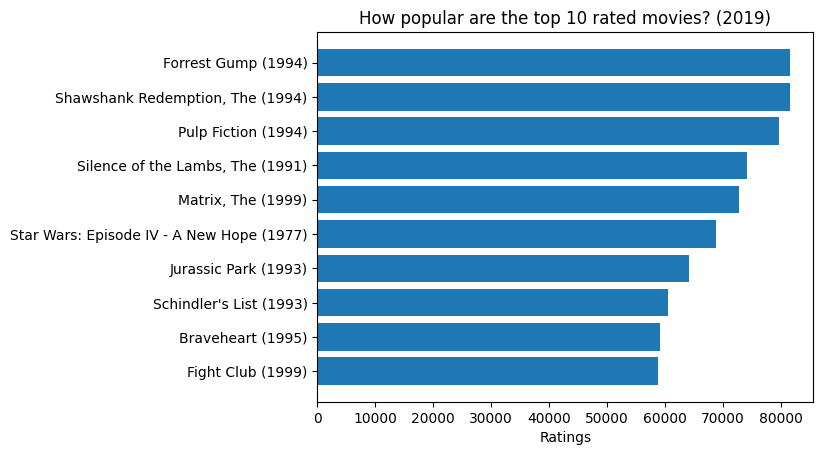

In [91]:
plot1_series = df_merge1.groupby('title')['rating'].count().sort_values(ascending=False).head(10)
top10movies = plot1_series.index.tolist()
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(top10movies))

ax.barh(y_pos, plot1_series, align='center')
ax.set_yticks(y_pos, labels=top10movies)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Ratings')
ax.set_title('How popular are the top 10 rated movies? (2019)')

plt.show()

### Distribution of Ratings
The distribution seems left skewed but that does make sense because a majority of movies are created to be enjoyable and often be rated high, as seen with over 6 million ratings are rating 4.

Text(0, 0.5, 'Frequency')

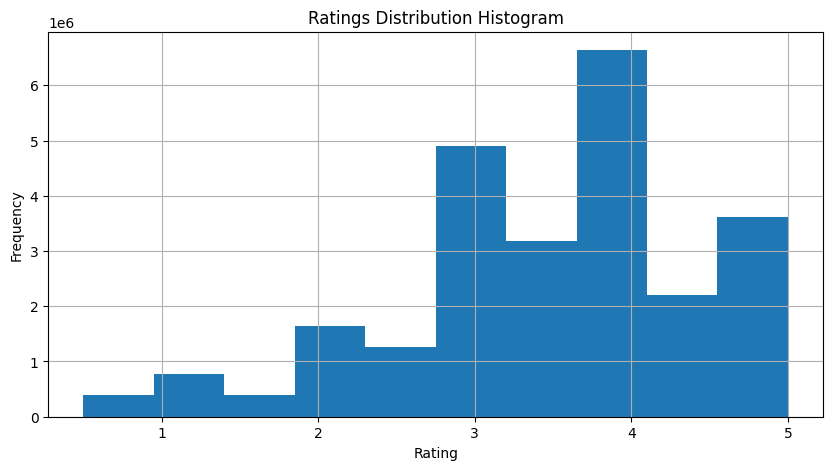

In [89]:
df_merge1.hist('rating', figsize=(10,5))
plt.title("Ratings Distribution Histogram")
plt.xlabel('Rating')
plt.ylabel('Frequency') 

### Top 10 Rated Genres
cant figure out this plot since genre is one-hot coded :/

# Modeling and Evaluation
* Different tasks will require different evaluation methods. Be as thorough as possible when analyzing
the data you have chosen and use visualizations of the results to explain the performance and
expected outcomes whenever possible. Guide the reader through your analysis with plenty of
discussion of the results. 

- #### Cluster Analysis 

    - Perform cluster analysis using several clustering methods
    - How did you determine a suitable number of clusters for each method?
    - Use internal and/or external validation measures to describe and compare the clusterings and the clusters (some visual methods would be good).
    - Describe your results. What findings are the most interesting and why? 

# Modeling and Evaluation
* Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?

    - How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
    - How would your deploy your model for interested parties?
    - What other data should be collected?
    - How often would the model need to be updated, etc.? 

#  Exceptional Work
* You have free reign to provide additional analyses or combine analyses